Per-genome rarefaction curves drawn using 
```
scripts/190308_gorg_rarefaction_tails.py
```

In [5]:
%matplotlib inline

import pandas as pd
import os.path as op
import os
from collections import Counter
import random
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import sklearn.metrics
import statistics
import math

def fit(df, x, y):
    
    def _check_fit(p, x, y):
        predicted = [p(i) for i in x]
        observed = y
        residuals = [x-y for x, y in zip(predicted, observed)]
        r2 = sklearn.metrics.r2_score(observed, predicted)
        stdev = np.std(residuals)
        return r2, stdev

    x = [float(i) for i in df[x].values]
    y = [float(i) for i in df[y].values]

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r2_order1, sd_order1 = _check_fit(p, x, y)
    return p, r2_order1, sd_order1


wd = "/mnt/scgc/simon/simonsproject/gorg-clustering/"
os.chdir(wd)


In [6]:
df = pd.read_csv("analyses/190308_tail_rarefaction_calculations.csv")
df1s = df[df['sag_start'] == 1]

In [7]:
means = []
sds = []
groups = []
for g in df1s['group'].unique():
    slopes = []
    for i in df1s[df1s['group'] == g]['iteration'].unique():

        idf = df1s[(df1s['group'] == g) & (df1s['iteration'] == i)]
        
        last_10 = idf[-10:].copy()
        last_10['count'] = np.arange(0, 10, 1)
        f = fit(last_10, 'count','clusters')
        slope = f[0][1]
        slopes.append(slope)
            
    mean_slopes = statistics.mean(slopes)
    sd_slopes = statistics.stdev(slopes)
    groups.append(g)
    means.append(mean_slopes)
    sds.append(sd_slopes)

rdf = pd.DataFrame(data={'group':groups, 'mean':means, 'stdev':sds})

In [8]:
genome_count = df.groupby(['group'])['sag_number'].max()

In [9]:
pdf = genome_count.reset_index().merge(rdf, on='group', how='right')
pdf.head()

,group,sag_number,mean,stdev
0,AEGEAN-169,413,47.594545,9.331591
1,ActinomarinaOM1,208,41.023030,5.179071
2,Arctic97B-4,13,740.872727,123.955019
3,Ascidiaceihabitans,12,707.263636,177.203825
4,Ca._Nitrosopumilales,15,176.323636,25.951460


In [10]:
groups = pd.read_excel('/mnt/scgc/simon/simonsproject/info/GORG_16S_basicinfo_20190123.xlsx')
mean_est_group_genome_size = groups.dropna(subset=['Estimated_genome_size']).groupby('Group_short')['Estimated_genome_size'].mean().reset_index().copy()
mean_est_group_genome_size.rename(columns={'Group_short':'group'}, inplace=True)

In [11]:
pdf = pdf.merge(mean_est_group_genome_size, on='group', how='left').sort_values(by='sag_number', ascending=False)

In [12]:
sns.set_style("whitegrid")
gcols = {'AEGEAN-169': '#9b4ec2',
 'ActinomarinaOM1': '#4cacdb',
 'NS4': '#469057',
 'NS5': '#5c6918',
 'Prochlorococcus': '#5753c0',
 'SAR116': '#d07ce1',
 'SAR86': '#d044ab',
 'Surface1_SAR11': '#a95f24',
 'Surface4_SAR11': '#b13a33',
 'Unclass_Rhodobacteraceae': '#4168a7',
 'Unclass_SAR11': '#da3956',
  'Other':'#A9A9A9'}

In [13]:
pdf['log_sag_number'] = [math.log(i, 10) for i in pdf['sag_number']]

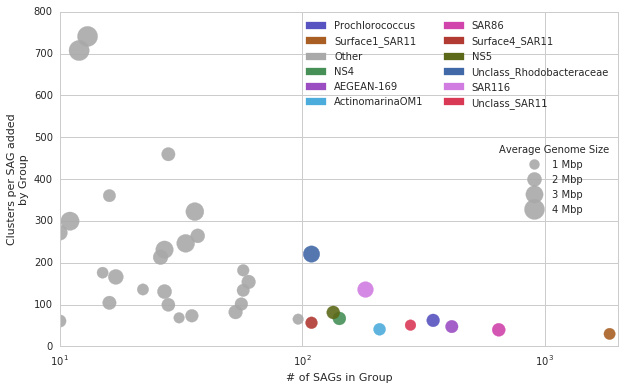

In [17]:
from matplotlib.patches import Patch


sizes = pdf['Estimated_genome_size'] * 100
pdf['color'] = [gcols.get(i, '#A9A9A9') for i in pdf['group']]

#for i, l in pdf.iterrows():
#    plt.errorbar(l['sag_number'], l['mean'], yerr = l['stdev'], fmt=",", color = l['color'], alpha=1)

plt.figure(figsize=(10,6))
plt.scatter('sag_number','mean', s=sizes, data=pdf, color = pdf['color'], alpha = 0.9)
plt.xlim(10,)
plt.ylim(0,)
plt.xlabel('# of SAGs in Group')
plt.ylabel('Clusters per SAG added\nby Group')
plt.xscale('log')

pdf['Estimated_genome_size']
size_legend = [1, 2, 3, 4] 
sizes = [i*100 for i in size_legend]
labels = ['1 Mbp','2 Mbp','3 Mbp','4 Mbp']

markers = []

for s in sizes:
    marker = plt.scatter([],[], s=s, color='#A9A9A9', alpha=0.9)
    markers.append(marker)

legend1 = plt.legend(handles=markers, labels=labels, loc='right',
    scatterpoints=1, title = 'Average Genome Size')

ax = plt.gca().add_artist(legend1)

legend_elements = [Patch(facecolor=gcols[i], edgecolor=gcols[i], label=i) for i in gcols]
plt.legend(handles=legend_elements, loc=0,
          fancybox=False, shadow=False, frameon=False, ncol=2)
